In [2]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cat = Table.read('CLAUDS_HSC_VISTA_Ks23.3_PHYSPARAM_TM.fits')

## Color vs. SF/Q

In [3]:
cat_gal = cat[cat['CLASS']==0]
cat_gal_z = cat_gal[abs(cat_gal['Z_BEST']-0.6)<0.01]

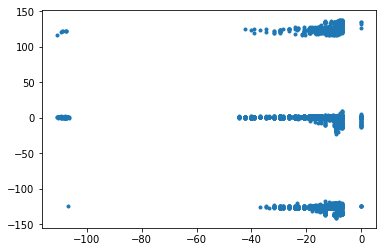

In [4]:
plt.plot(cat_gal['SSFR_BEST'],cat_gal['g']-cat_gal['r'],'.')
# plt.xlim([-12,-8])
# plt.ylim([-2,2])
plt.show()

## Combine Errors 
photoz/mass error & Counting error

In [5]:
def combine_deep_bootstrap(run_number):
    path = 'CUT_deep_catalogs/combine_err/'
    cosmos_deep = np.genfromtxt(path+'COSMOS_deep_bootstrap_0.6.txt')[run_number]
    sxds_uddd = np.genfromtxt(path+'SXDS_uddd_bootstrap_0.6.txt')[run_number]
    elais_deep = np.genfromtxt(path+'ELAIS_deep_bootstrap_0.6.txt')[run_number]
    xmmlss_deep = np.genfromtxt(path+'XMM-LSS_deep_bootstrap_0.6.txt')[run_number]
    deep_deep = np.genfromtxt(path+'DEEP_deep_bootstrap_0.6.txt')[run_number]
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    radial_cosmos = cosmos_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_sxds = sxds_uddd[1:((len(cosmos_deep)-1)/2)+1]
    radial_elais = elais_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_xmmlss = xmmlss_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_deep = deep_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_combine = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    return radial

In [6]:
radial_combined = np.array([])
for run in range(99):
    radial = combine_deep_bootstrap(run)
    if run==0:
        radial_combined = radial
    else:
        radial_combined = np.vstack((radial_combined,radial))

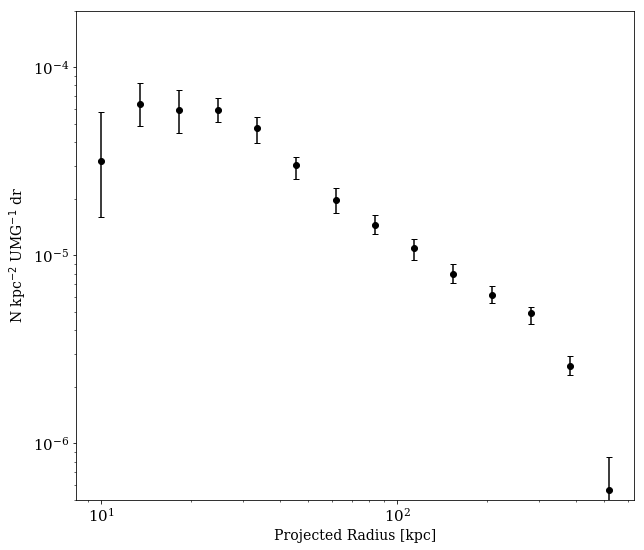

In [7]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig = plt.figure(figsize=(10, 9))


bin_edges = np.load('CUT_deep_catalogs/combine_err/bin_edges.npy')[:-1]

median = np.median(radial_combined, axis=0)
percent16 = np.percentile(radial_combined,16, axis=0)
percent84 = np.percentile(radial_combined,84, axis=0)

plt.errorbar(bin_edges,median,yerr=[median-percent16,percent84-median],fmt='ok',capsize=3)

plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.savefig('figures/combined_err.png')
plt.show()

## Calibration uddd & deep

In [8]:
cat = Table.read('CUT_deep_catalogs/massive_counts_inside/ELAIS_deep_0.09_11.15.fits')
cat

zphot,count,count_q,count_sf
float64,float64,float64,float64
0.3,225.0,201.0,24.0
0.4,323.0,275.0,48.0
0.5,251.0,209.0,42.0
0.6,411.0,304.0,107.0
0.7,482.0,327.0,155.0
0.8,797.0,367.0,430.0
0.9,1022.0,402.0,619.0
1.0,438.0,161.0,276.0


In [9]:
def combine_deep(mass_bin, csfq, ssfq, z, mode='count',path='CUT_deep_catalogs/calibration_deep/'):
    z=round(z,1)
    def massive_counts(cat_name,z,csfq):
        cat = Table.read('CUT_deep_catalogs/massive_counts_inside/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
            
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')

    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq)
    count_DEEP = massive_counts('DEEP_deep',z,csfq)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total               
    return radial_total, radial_total_err

In [10]:
path = 'CUT_deep_catalogs/calibration_deep/'
radial_deep_sf = combine_deep(masscut,'all','ssf',1.0,path=path)
print(radial_deep_sf)

NameError: name 'masscut' is not defined

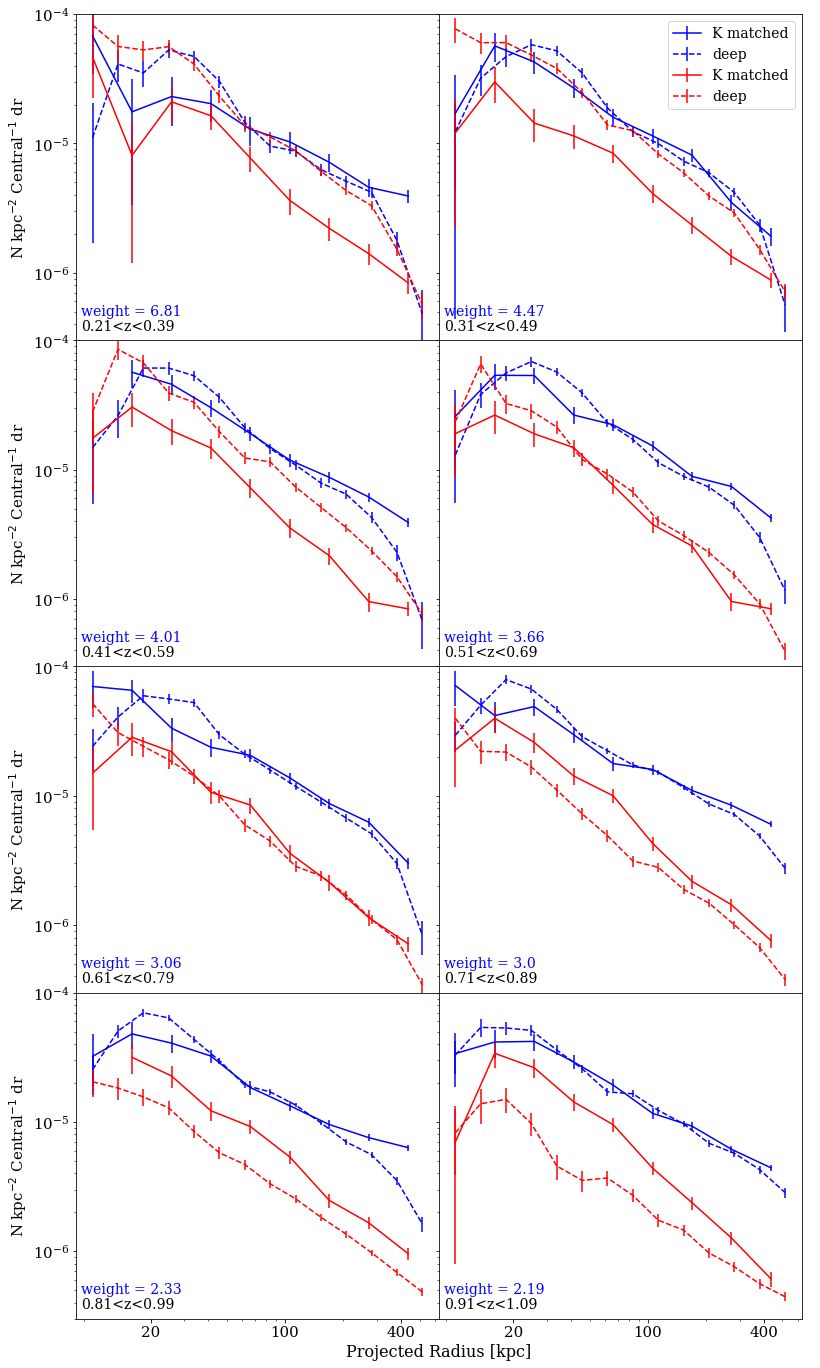

In [11]:
import matplotlib

masscut='9.5'
path = 'CUT_deep_catalogs/calibration_deep/'

bin_edges = np.load(path+'bin_edges.npy')[:-1]
new_bin_edges = np.load('calibration_uddd/new_bin_edges.npy')[:-1]

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(13,24))
weights=[]
for i in range(4):
    for j in range(2):
        z = 0.3 + i/5.+j/10.
        z_bin_size = 0.09
            
        radial_deep_sf = combine_deep(masscut,'all','ssf',z,path=path)
        radial_uddd_sf = np.load('calibration_uddd/count_'+masscut+'_ssf_'+str(z)+'.npy')
        radial_uddd_sf_err = np.load('calibration_uddd/count_'+masscut+'_ssf_'+str(z)+'_err.npy')
        radial_uddd_sf = (radial_uddd_sf, radial_uddd_sf_err)
        
        radial_deep_q = combine_deep(masscut,'all','sq',z,path=path)
        radial_uddd_q = np.load('calibration_uddd/count_'+masscut+'_sq_'+str(z)+'.npy')
        radial_uddd_q_err = np.load('calibration_uddd/count_'+masscut+'_sq_'+str(z)+'_err.npy')
        radial_uddd_q = (radial_uddd_q, radial_uddd_q_err)
        
        deep_interp = np.interp([50,100,150],bin_edges,radial_deep_sf[0])
        uddd_interp = np.interp([50,100,150],new_bin_edges,radial_uddd_sf[0])  
        weight = np.cbrt((deep_interp[0]/uddd_interp[0])*(deep_interp[1]/uddd_interp[1])*(deep_interp[2]/uddd_interp[2]))
        weights.append(weight)
        
        axs[i][j].errorbar(new_bin_edges,radial_uddd_sf[0]*weight,radial_uddd_sf[1]*np.sqrt(weight),
                           label='K matched',fmt='b')
        axs[i][j].errorbar(bin_edges,radial_deep_sf[0],radial_deep_sf[1],
                           label='deep',fmt='--b')
        axs[i][j].errorbar(new_bin_edges,radial_uddd_q[0],radial_uddd_q[1],
                           label='K matched',fmt='r')
        axs[i][j].errorbar(bin_edges,radial_deep_q[0],radial_deep_q[1],
                           label='deep',fmt='--r')
        
        axs[i][j].annotate(str(z-z_bin_size)+'<z<'+str(z+z_bin_size),(5,10), fontsize=14, xycoords='axes points')
        axs[i][j].annotate('weight = '+str(round(weight,2)),(5,25), fontsize=14, xycoords='axes points',color='b')
        
    axs[i][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)

axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_ylim([3e-7,1e-4])
axs[0][1].legend(fontsize=14)
axs[3][0].set_xticks([20, 100, 400])
axs[3][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.savefig('figures/calibraion_uddd_deep_z.png')
plt.show() 

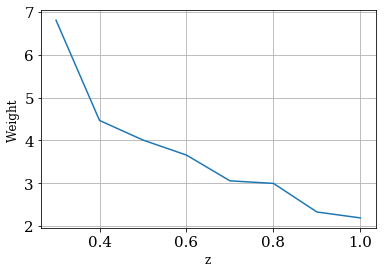

In [12]:
plt.plot(np.arange(0.3,1.01,0.1),weights)
plt.xlabel('z',fontsize=12)
plt.ylabel('Weight',fontsize=12)
plt.grid()
plt.savefig('figures/weight_z.png')
plt.show()

[0.46153846 0.85714286 0.93548387 0.95789474 0.94382022 0.9198895
 0.94408946 0.95498875 0.95111624 0.95245458 0.95173547 0.95228838]
[0.4        0.8        0.91666667 0.94029851 0.92857143 0.90559441
 0.93970894 0.94995093 0.94254581 0.94485842 0.94451783 0.94532981]
[0.66666667 1.         1.         1.         1.         0.97368421
 0.95862069 0.97133758 0.98100173 0.97909408 0.97693727 0.97656445]

In [13]:
def combine_deep2(csfq, ssfq,mass_bin, z, mode='count',path = 'CUT_deep_catalogs/calibration_deep/',inside_flag=True):
    
    def massive_counts(cat_name,z,csfq,indside_flag):
        if inside_flag==True:
            cat = Table.read('CUT_deep_catalogs/massive_counts_inside/'+cat_name+'_0.09_11.15.fits')
        else:
            cat = Table.read('CUT_deep_catalogs/massive_counts/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq,inside_flag)
    count_DEEP = massive_counts('DEEP_deep',z,csfq,inside_flag)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq,inside_flag)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq,inside_flag)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq,inside_flag)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])
    print('total number of centrals:',count_total)

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
                               
    return radial_total, radial_total_err

## radius completeness correction

('total number of centrals:', 1708.0)
('total number of centrals:', 1708.0)


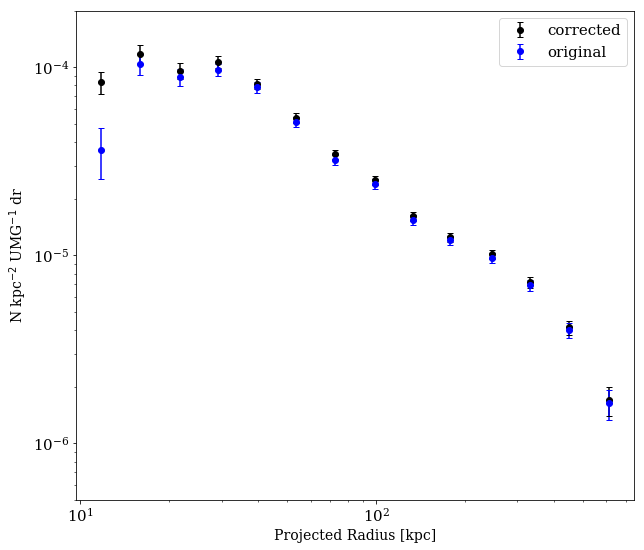

In [14]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig = plt.figure(figsize=(10, 9))
comp_curve = np.load('CUT_deep_catalogs/completeness.npy')
bin_centers = np.load('CUT_deep_catalogs/calibration_deep/bin_centers.npy')
old_bkg = combine_deep2('all','all','9.5',0.6,path='CUT_deep_catalogs/calibration_deep/')
new_bkg = combine_deep2('all','all','9.5',0.6,path='CUT_deep_catalogs/new_bkg/')

plt.errorbar(bin_centers,new_bkg[0]/comp_curve,yerr=new_bkg[1],fmt='ok',capsize=3,label='corrected')
plt.errorbar(bin_centers,new_bkg[0],yerr=new_bkg[1],fmt='ob',capsize=3,label='original')

plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-7,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.legend(fontsize=15)
plt.savefig('figures/radial_comp_corr.png')
plt.show()

In [15]:
pwd

u'/home/lejay/research/Winter_2018'

## Host Mass Dependence

In [4]:
def combine_deep_new(masscut_h_low,z,csfq, ssfq):
    path = 'CUT_deep_catalogs/split_host_mass/'
    affix = '_host_'+str(masscut_h_low)+'_9.5_'+csfq+'_'+ssfq+'_'+str(z)
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    radial_cosmos = cosmos_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_sxds = sxds_uddd[1:((len(cosmos_deep)-1)/2)+1]
    radial_elais = elais_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_xmmlss = xmmlss_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_deep = deep_deep[1:((len(cosmos_deep)-1)/2)+1]
    radial_combine = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_sxds_err = sxds_uddd[((len(cosmos_deep)-1)/2)+1:]
    radial_elais_err = elais_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_xmmlss_err = xmmlss_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_deep_err = deep_deep[((len(cosmos_deep)-1)/2)+1:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial,radial_err)

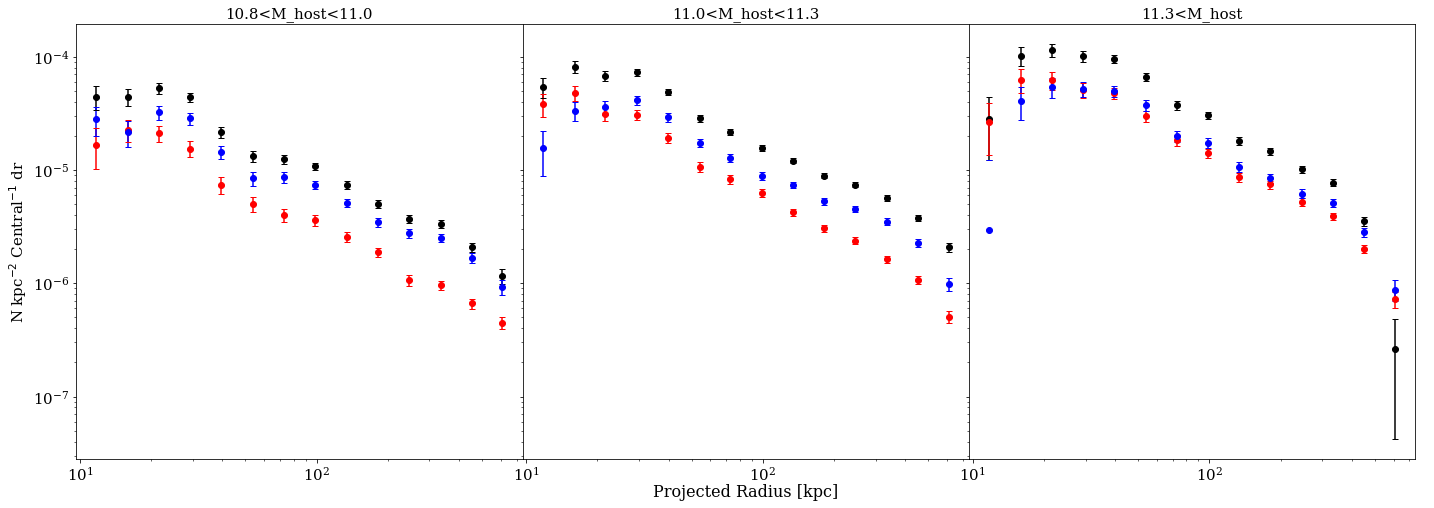

In [10]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,8))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
radial_host_lm = combine_deep_new(10.8,0.6,'all','all')
radial_host_mm = combine_deep_new(11.0,0.6,'all','all')
radial_host_hm = combine_deep_new(11.3,0.6,'all','all')

radial_host_lm_sf = combine_deep_new(10.8,0.6,'all','ssf')
radial_host_mm_sf = combine_deep_new(11.0,0.6,'all','ssf')
radial_host_hm_sf = combine_deep_new(11.3,0.6,'all','ssf')

radial_host_lm_q = combine_deep_new(10.8,0.6,'all','sq')
radial_host_mm_q = combine_deep_new(11.0,0.6,'all','sq')
radial_host_hm_q = combine_deep_new(11.3,0.6,'all','sq')

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='or',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='ob',capsize=3)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ok',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='or',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='ob',capsize=3)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='ok',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='or',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='ob',capsize=3)

axs[0].set_title('10.8<M_host<11.0',fontsize=15)
axs[1].set_title('11.0<M_host<11.3',fontsize=15)
axs[2].set_title('11.3<M_host',fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.savefig('figures/split_host_mass_sfProb.png')
plt.show()

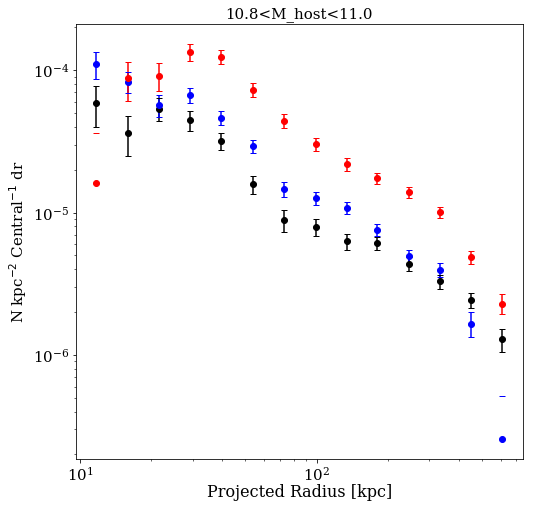

In [8]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,8))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
z=0.3
radial_host_lm = combine_deep_new(10.8, z,'cq','all')
radial_host_mm = combine_deep_new(11.0, z,'cq','all')
radial_host_hm = combine_deep_new(11.3, z,'cq','all')

axs.errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='ok',capsize=3)
axs.errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='ob',capsize=3)
axs.errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='or',capsize=3)


axs.set_title('10.8<M_host<11.0',fontsize=15)
# axs[1].set_title('11.0<M_host<11.3',fontsize=15)
# axs[2].set_title('11.3<M_host',fontsize=15)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.savefig('figures/calibraion_uddd_deep_z.png')
plt.savefig('figures/split_host_mass_cq_'+str(z)+'.png')
plt.show()

In [18]:
pwd

u'/home/lejay/research/Winter_2018'

('total number of centrals:', 1708.0)
('total number of centrals:', 1708.0)
('total number of centrals:', 1708.0)
('total number of centrals:', 1708.0)


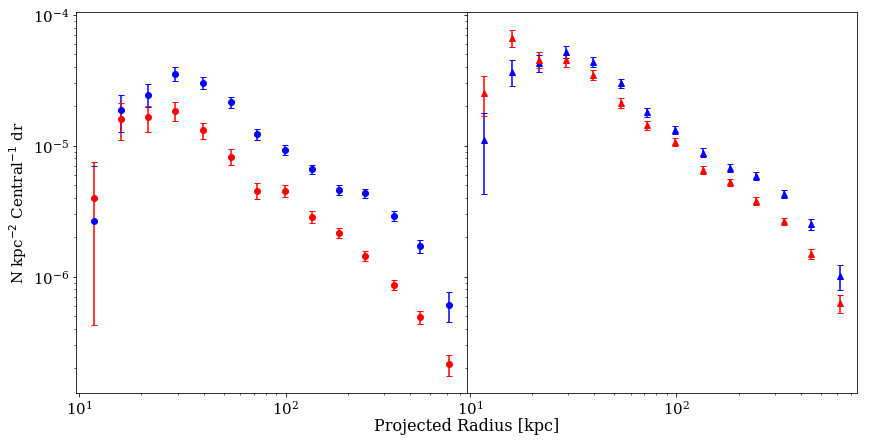

In [19]:
# USE of sfProb

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7))

radial_old_sf = combine_deep2('all', 'ssf','9.5', 0.6, path='CUT_deep_catalogs/test_sfProb/')
radial_old_q = combine_deep2('all', 'sq','9.5', 0.6, path='CUT_deep_catalogs/test_sfProb/')
radial_new_sf = combine_deep2('all', 'ssf','9.5', 0.6, path='CUT_deep_catalogs/test_sfProb/sfProb_')
radial_new_q = combine_deep2('all', 'sq','9.5', 0.6, path='CUT_deep_catalogs/test_sfProb/sfProb_')
bin_centers = np.load('CUT_deep_catalogs/test_sfProb/bin_centers.npy')

axs[0].errorbar(bin_centers,radial_old_sf[0],yerr=radial_old_sf[1],fmt='ob',capsize=3)
axs[1].errorbar(bin_centers,radial_new_sf[0],yerr=radial_new_sf[1],fmt='^b',capsize=3)
axs[0].errorbar(bin_centers,radial_old_q[0],yerr=radial_old_q[1],fmt='or',capsize=3)
axs[1].errorbar(bin_centers,radial_new_q[0],yerr=radial_new_q[1],fmt='^r',capsize=3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.savefig('figures/calibraion_uddd_deep_z.png')
plt.savefig('figures/test_sfProb.png')
plt.show()

## Link through Redshift (with evolving mass cut)